## Transformer Model Intuition

Attention + CNN style

Transformer is more akin to the CNN style parallel processing.


Two key ideas:

- Self-Attention: If we have 5 words we calculate 5 representations with attention mechanism in parallel.
- Multi-Head Attention: Actually we calculate multiple representations for each word in parallel.

## Self-Attention

**Notation**

For each input word, we have three vectors representing them. In previous Attention architecture, we only calculated one e vector. Now we have three:

$$
A^{<1>} \rightarrow A(q,K,V) = \sum_i \dfrac{exp(q \cdot k^{<i>})}{\sum_j exp(q \cdot k^{<j>})} v^{<i>}
$$

Intuition is, for example take the word Africa. It might mean the continent itself, it might be referring to the African food, or it might refer to some other concept. What a word is referring to can be better understood if we take into account the neighboring context. So we use keys (K) and values (V) of other representations to learn the attention representation.


For each word we have three vectors:

- query:  $q^{<1>},q^{<2>},q^{<3>},q^{<4>},q^{<5>}$
- key: $k^{<1>},k^{<2>},k^{<3>},k^{<4>},k^{<5>}$
- value: $v^{<1>},v^{<2>},v^{<3>},v^{<4>},v^{<5>}$


And these are all learned using specialized Weight matrices:

$$
q^{<3>} = W^{Q} \cdot x^{<3>}\\
k^{<3>} = W^{K} \cdot x^{<3>}\\
v^{<3>} = W^{V} \cdot x^{<3>}
$$


Loose analogy:

- q is the question we ask
- we take inner product with k which gives us the relevance of that word (like strength)
- then by multiplying with $v$ we incorporate the value of the word proportional to its relevance. 


Now the key idea is that, with this approach, embedding for Africa is not a fixed representation but depends on its context.


### Vectorized Representation


In literature we would simplify calculating self-attention for all input steps by the following:

$$
Attention(Q,K,V) = softmax(\dfrac{QK^T}{\sqrt{d_k}}) V
$$

Denominator is just for scaling the dot product so it doesn't explode.

It is also called **Scaled Dot Product Attention**.

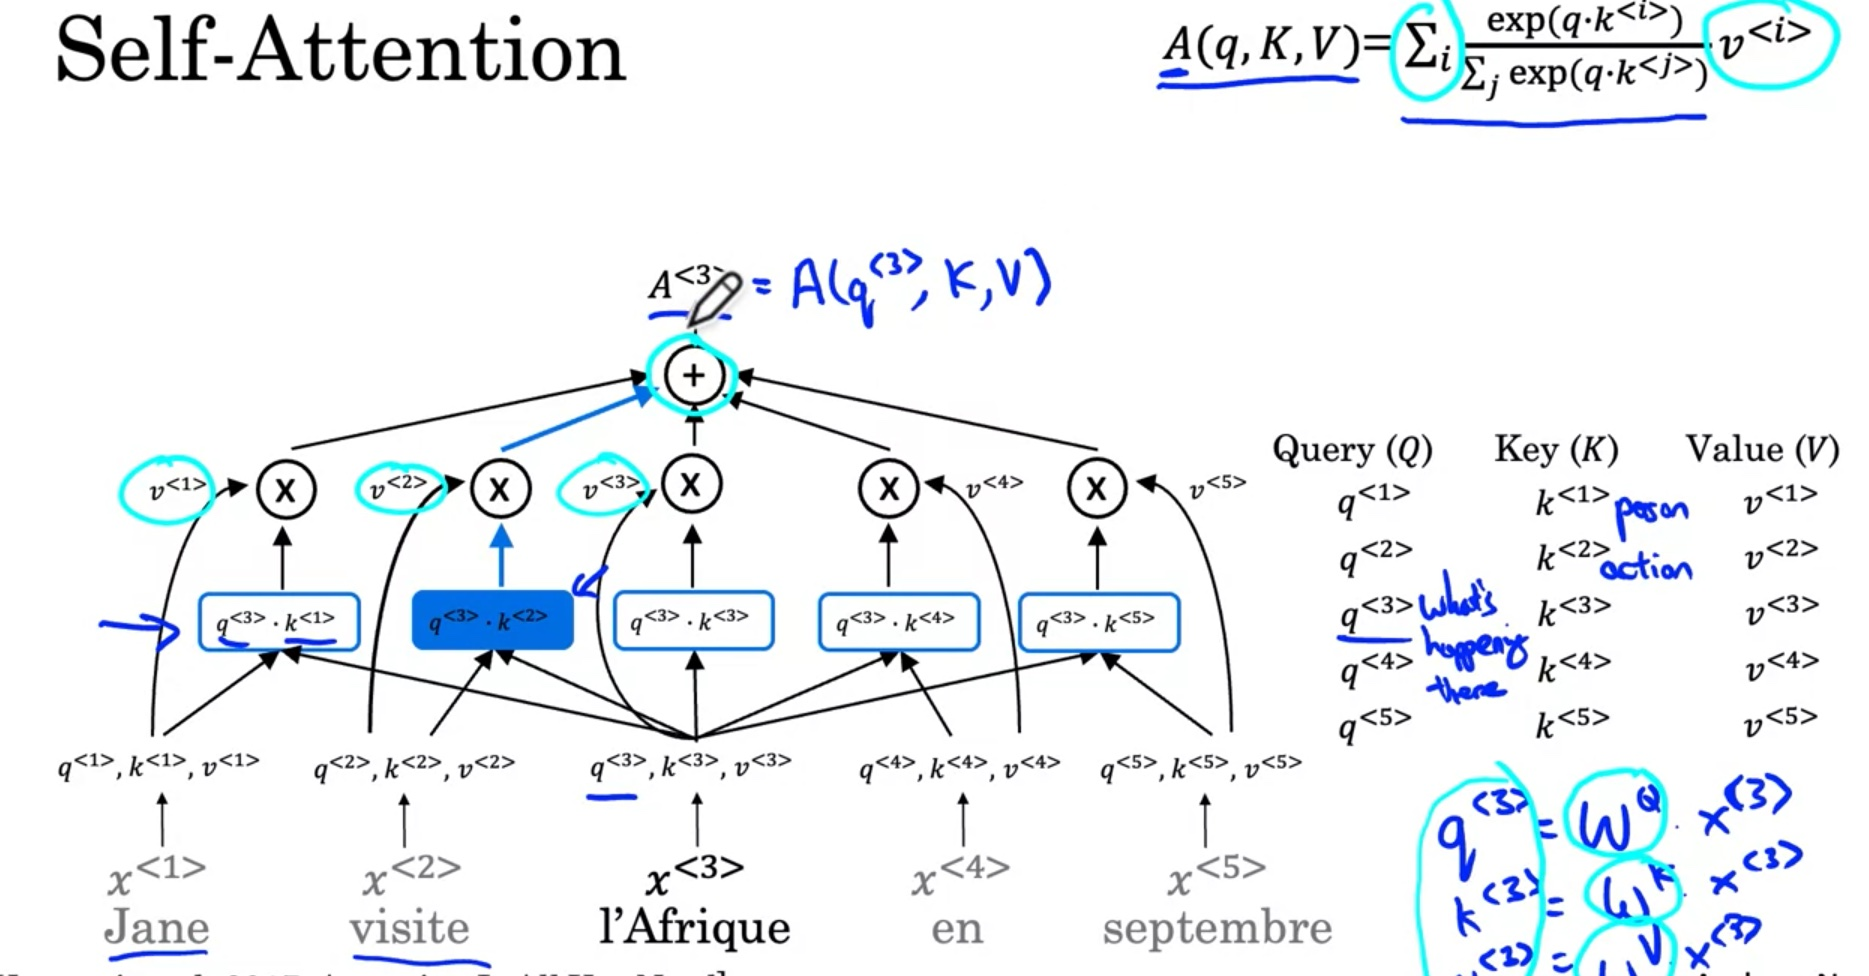

In [3]:
from IPython.display import Image
Image(filename='../../assets/self-attention.jpg')

## Multi-Head Attention

Add a big for loop on self-attention idea. In practice of course we will calculate them in parallel

Each self-attention is called a "head". So we will have multiple heads.


Example 

    Jane visits Africa in September.

Let's again take the word "Africa"

- So the aim of attention is to understand which words in the context relate to the word we have.

- However, having only one head has the drawback that depending on the question, different words might have different contributions. 

- For example, we can have a head for "who?" in which case first word is important. 

- Another question might be "when?" in which case the last word should have a high relevance.

- Multi-head attention is like calculating different features for each word and then concatenating them.


**Mathematical Formulation**

For each head ($j$) we will have $W_j^{Q},W_j^{K},W_j^{V}$. Then we can apply the same Attention mechanism from the previous step by doing the following:

$$
head_j = Attention(W_j^{Q}Q,W_j^{K}K,W_j^{V}V)\\
MultiHead(Q,K,V) = concat(head_1,head_2,..., head_h) \cdot W_o
$$


where $W_o$ is the final weight matrix to get the multi-head representations for all words. $h$ denotes number of heads. Notice that the exact same Attention method is applied only difference is we transform the Q,K,V for each head.


Notice that exactly the same matrix $W_j^{Q}$ etc. are multiplied with the representations for ALL words. so it is almost like we apply the same CNN filter over each word with stride=1 kernel_size=1 and then pass those to the Attention computation.


**Note** In the simplest case of multi-headed self-attention, we actually use:

$$
q=k=v=x
$$

So we don't multiply with a Weight matrix twice for each head (one for going from $x_1$ to $q_1,k_1,v_1$ and another to get the head1 inputs). We only do it once (multiply $x_1$ with head1's matrices).

In the below image, it shows the opposite case where we Q,K,V matrices instead of the input directly.

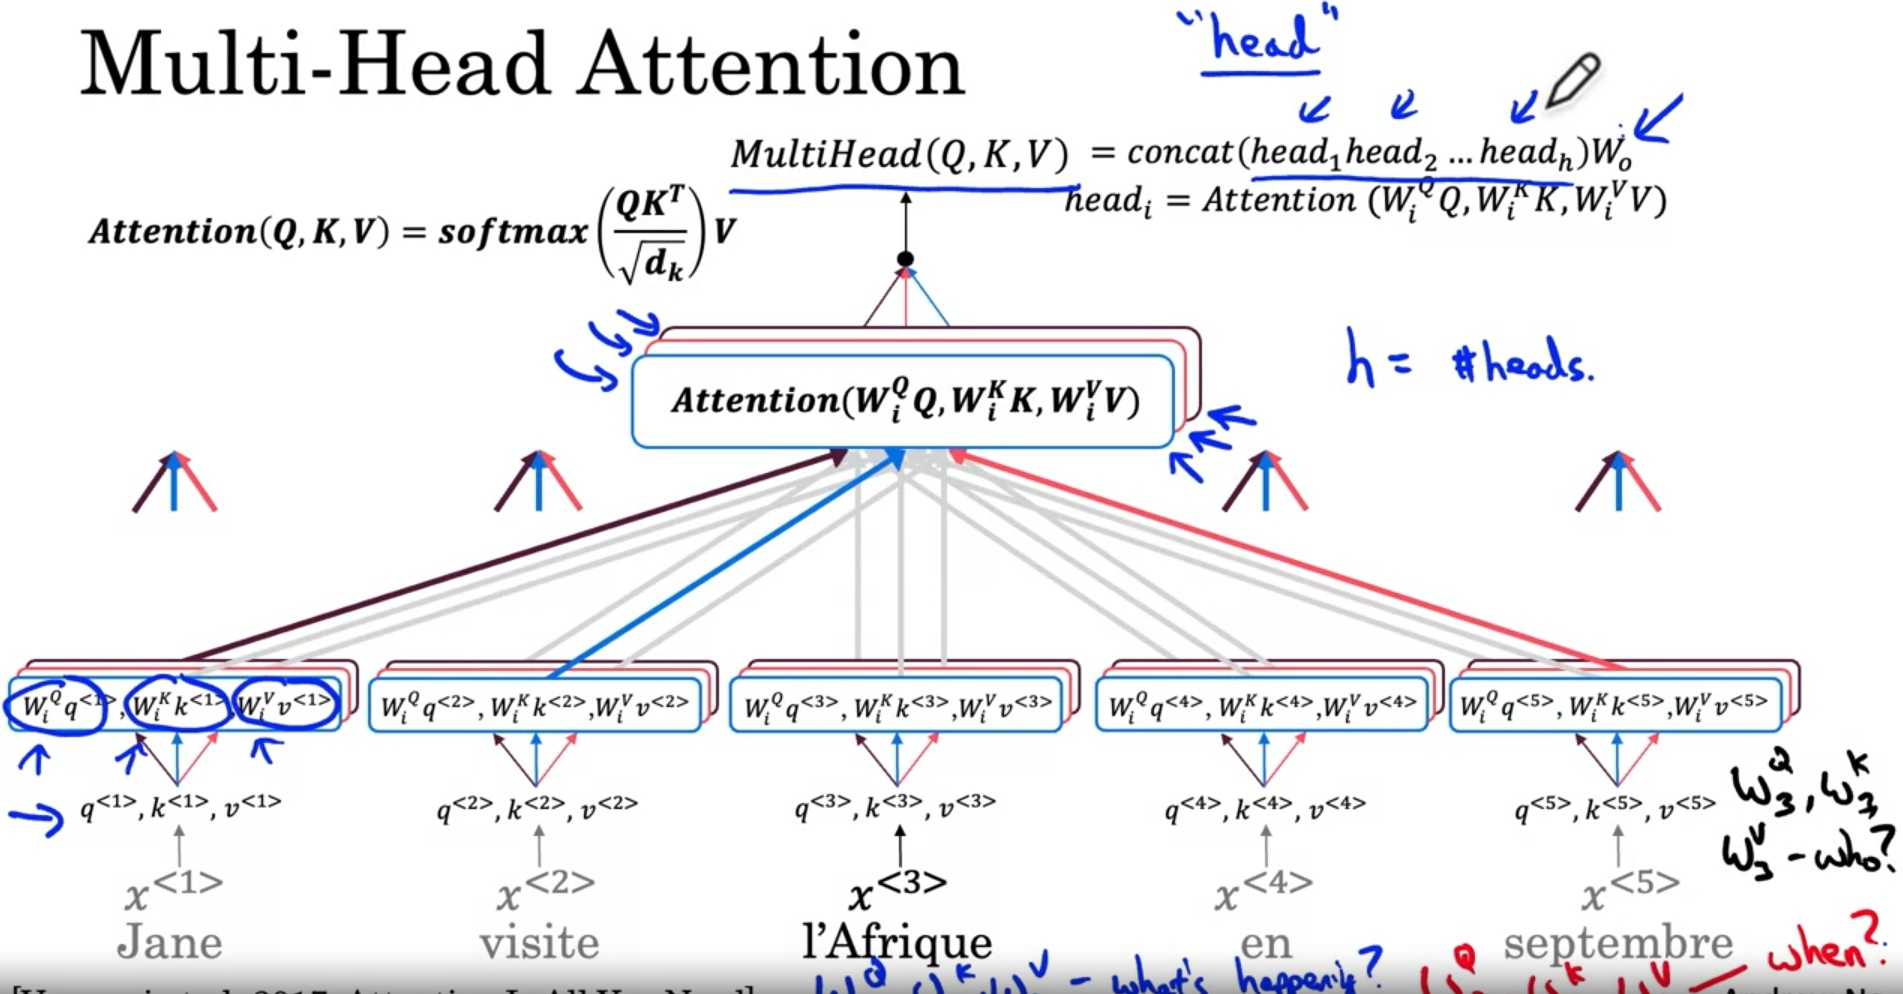

In [4]:
from IPython.display import Image
Image(filename='../../assets/multihead_attention.jpg')


## Transformer Network

Let's walk through a complete example of transformer for the translation task 

    Input: Jane visite l'Afrique en septembre.
    Output: Jane visits Aftica in September. (expected)
    
- It is common to actually include \<SOS\> and \<EOS\> to denote the boundaries in the input.


**Encoder**

Consists of vertically stacked Encoder blocks (typical value is 6):

- Multi-Head Attention
- Feed Forward Neural Network

Outputs a representation for each input step and we input these to the decoder.


**Decoder**

Consists of vertically stacked Decoder blocks (typical value is 6):

- Step 0: We know the newly generated sequence will start empty. So we input the \<SOS\> token to the decoder.

- We compute a multi-head attention based on this (only one token)

- Second layer of multi-head attention receives these inputs:
    - Q comes from the previous step of the decoder multi-head
    - K,V comes from the output of the encoder  
    - Intuition: We condition the decoding to the input tokens by doing the second layer multi-head connected to the encoder outputs
- Then we follow that by Feed Forward Neural Network


Decoding is done one step at a time. So after we generate "Jane" then the first multi-head in the decoder will output 2 query vectors.


### Extra Details

**Positional Encodings**

$d$ denotes the dimension of the embedding.

$pos$ is the position of the word. so for $w_1$, $pos=1$

Note that $i$ looks like it is repeated because we start from 0 and go even, odd, even, odd. Evens are generated by $2i$ and odds are generated by $2i+1$. 

- If we have 768 dimensions, we generate 384 sin and 384 cosines graphs. These are increasingly larger and larger sines and cosines since i increases the denominator.
- We then pick different points in this 768 graphs, by shifting the vertical slice by one 

$$
PE_{(pos,2i)} = sin(\dfrac{pos}{10000^{2i/d}})\\
PE_{(pos,2i+1)} = cos(\dfrac{pos}{10000^{2i/d}})
$$

We simply do element-wise addition the word embedding and the positional embedding.

So if your output of encoding layer is `d` dimensional (lets say 768), all layers and all outputs are also 768 dimensional.



### Residual Connections

In addition to adding the PEs to embeddings, we connect them to upper layers using residual connections so position information is passed on to all layers in the network.

This is achieved using "ADD & Norm" similar to BatchNorm



#### Masked Multi-Head

- Only relevant for training

- Multi-head Attention repeatedly maskes the consecutive words so in one batch we can predict all words in the reference translation at once.


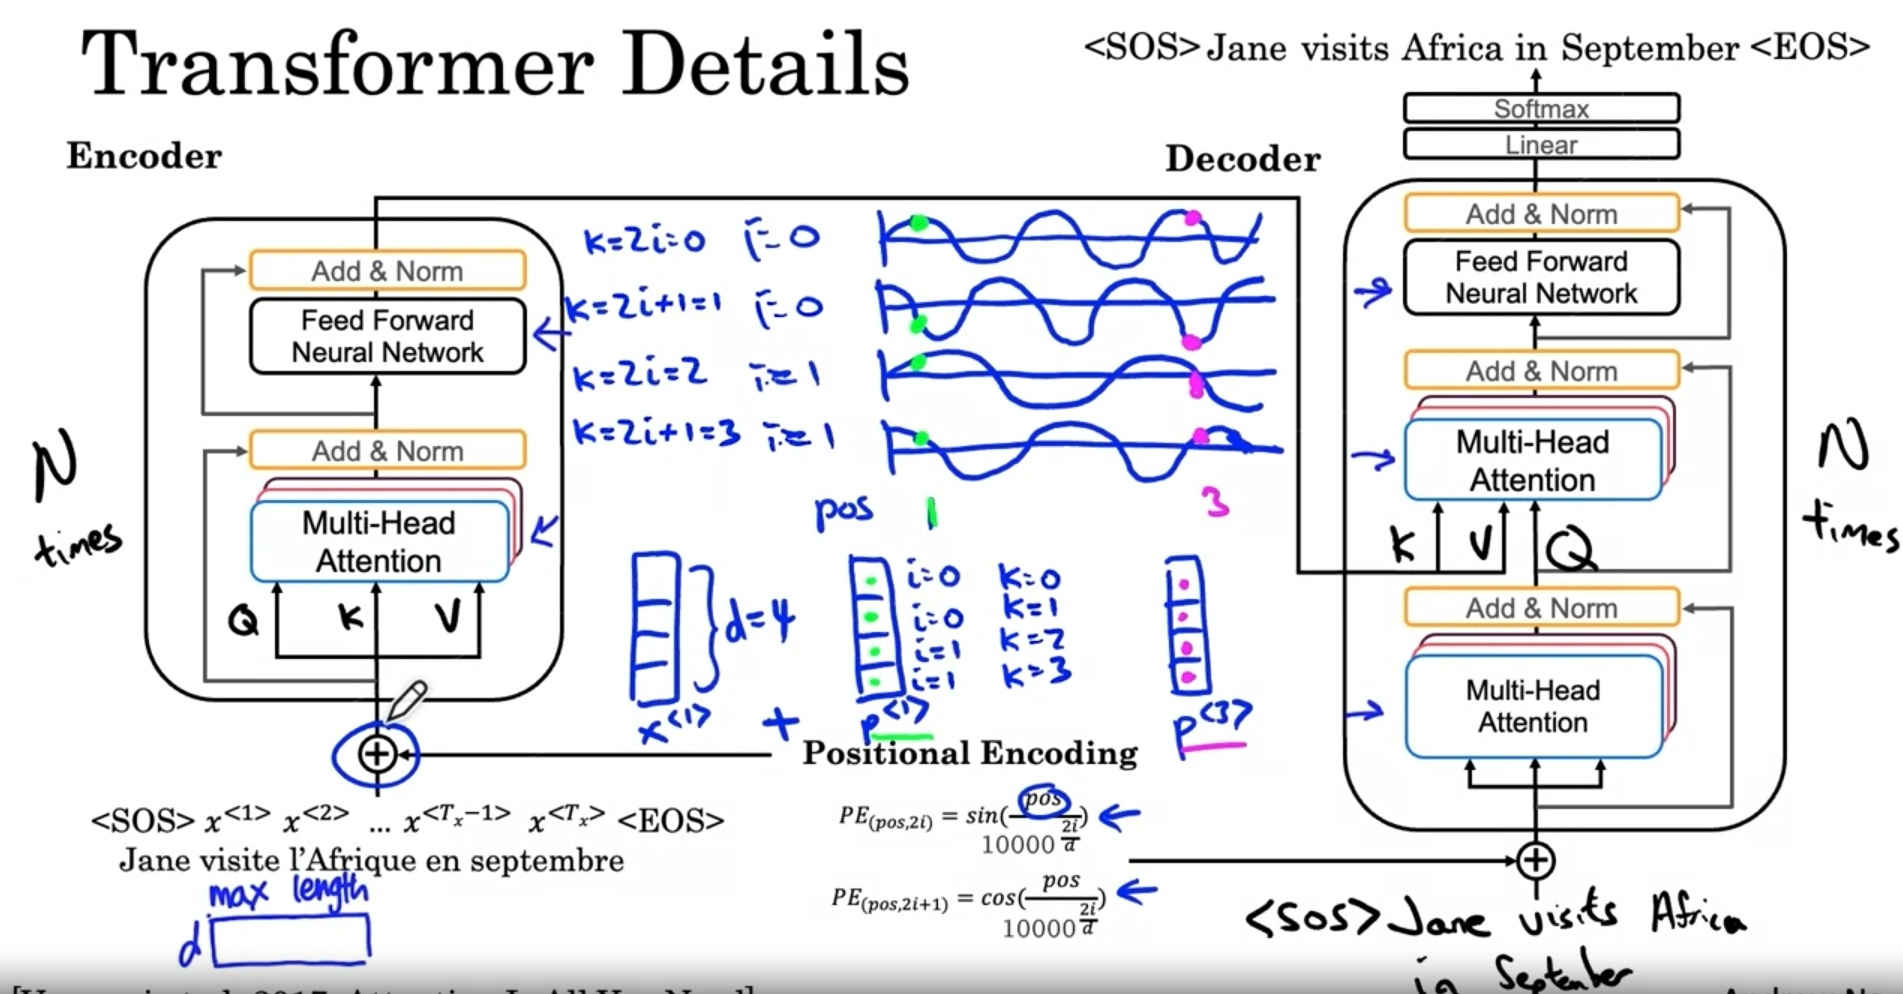

In [8]:
Image(filename='../../assets/transformer-full.jpg')
